Open Set Recognition with fastai-v2 using bce loss function suggested in [Lesson 9](https://forums.fast.ai/t/lesson-9-discussion-wiki-2019/41969/511) of Part2 2019 and described in [DOC: Deep Open Classification of Text Documents](https://arxiv.org/abs/1709.08716).

Todo - compare with:
1. [Bayesian deep learning with Fastai](https://towardsdatascience.com/bayesian-deep-learning-with-fastai-how-not-to-be-uncertain-about-your-uncertainty-6a99d1aa686e)
2. Methods described in [Recent Advances in Open Set Recognition: ASurvey](https://arxiv.org/pdf/1811.08581.pdf)

In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.notebook.showdoc import *
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

## Shared Init

In [2]:
num_workers = 0 # windows
pat = r'\\([^\\]+)_\d+.jpg$' # windows
bs = 64
seed = 2
valid_pct = 0.2
test_pct = 0.2
n_wild_classes = 2
path = untar_data(URLs.PETS)
path_img = path/'images'
item_tfms=RandomResizedCrop(460, min_scale=0.75)
batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize(*imagenet_stats)]
model = xresnet50_deeper

In [3]:
def create_dbunch(cat_block,valid_pct,seed,label_func,fnames,path,item_tfms,bs,num_workers,batch_tfms):
    dblock = DataBlock(blocks=(ImageBlock, cat_block),
                   splitter=RandomSplitter(valid_pct, seed=seed),
                   get_y=label_func)
    return DataBunch.from_dblock(dblock, fnames, path=path, item_tfms=item_tfms,bs=bs,
                                  num_workers=num_workers, batch_tfms=batch_tfms)

In [4]:
class TestData():
    def __init__(self,fnames,labeller,valid_dbunch):
        self.fnames = fnames
        self.labeller = labeller
        self.y_labeled = L(map(self.labeller,self.fnames));
        if isinstance(self.y_labeled [0],list): # works with bce labellers
            self.y_labeled  = [item for sublist in self.y_labeled  for item in sublist]
            assert len(self.y_labeled ) == len(self.fnames)
        _,self.o2i = uniqueify(self.y_labeled, sort=True, bidir=True)
        self.y = torch.from_numpy(np.array(L(map(self.o2i.get,self.y_labeled))))
        self.i2o = {value: key for key, value in self.o2i.items()}
        self.n_classes = len(self.o2i)
        self.n = len(self.y)
        self.dl = test_dl(valid_dbunch,self.fnames)

## Split data

In [5]:
fnames = get_image_files(path_img)
labeller = RegexLabeller(pat)
y_string = list(map(labeller, fnames))
vocab,o2i = uniqueify(y_string, sort=True, bidir=True)
y = np.array(list(map(o2i.get,y_string)))

Remove the wild animals from the training data

In [6]:
i_wild_classes = np.random.permutation(len(vocab))[:n_wild_classes]
i_wild_classes =  [29, 15] # fix for examination
print(f'Wild Classes: {i_wild_classes}')

Wild Classes: [29, 15]


In [7]:
mask = np.full(len(y), False)
for i in i_wild_classes: mask = mask | (y == i)
fnames_wild = [fname for (fname,mask_val) in zip(fnames, mask) if mask_val]
fnames_pets = [fname for (fname,mask_val) in zip(fnames, mask) if not mask_val]

Split out a test data set for comparisson of  ce and bce

In [8]:
i_trn_val,i_test = RandomSplitter(valid_pct=test_pct,seed=seed)(fnames_pets)
fnames_test = [fnames_pets[i] for i in i_test]
fnames_train_valid = [fnames_pets[i] for i in i_trn_val]

In [9]:
assert len(fnames) == len(fnames_wild) + len(fnames_train_valid) + len(fnames_test)
assert len(set(fnames).intersection(fnames_wild)) == len(fnames_wild)
assert len(set(fnames).intersection(fnames_train_valid)) == len(fnames_train_valid)
assert len(set(fnames).intersection(fnames_test)) == len(fnames_test)
assert len(set(fnames).intersection(fnames_wild + fnames_train_valid + fnames_test)) == len(fnames)
assert len(set(fnames_wild).intersection(fnames_train_valid)) == 0
assert len(set(fnames_wild).intersection(fnames_test)) == 0
assert len(set(fnames_train_valid).intersection(fnames_test)) == 0

## Train pets model with - CrossEntropyLoss()

### Setup

In [42]:
save_stem = f'{model.__name__ }_ce_ex_{"_".join(map(str, i_wild_classes))}'

In [43]:
label_func = RegexLabeller(pat)
dbunch = create_dbunch(CategoryBlock,valid_pct,seed,label_func,fnames_train_valid,path,item_tfms,bs,num_workers,
                       batch_tfms)

In [44]:
learn = cnn_learner(dbunch, model, metrics=error_rate).to_fp16()

### Train

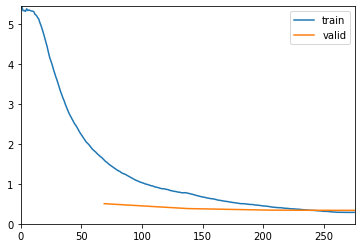

In [22]:
save_name = save_stem + '_1'
learn.fit_one_cycle(4, cbs=[ShowGraphCallback(),
                            SaveModelCallback(monitor='error_rate',fname=save_name,comp=np.less)])

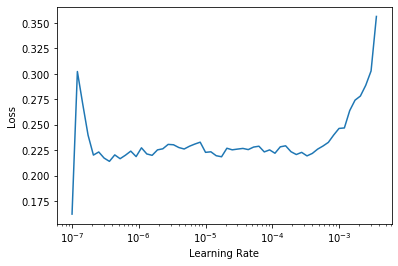

In [23]:
save_name = save_stem + '_1'
learn.load(save_name)
learn.unfreeze()
learn.lr_find()

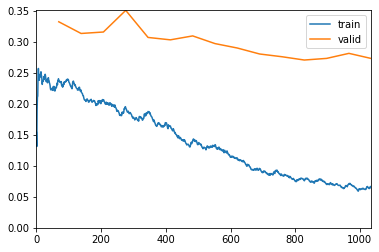

In [24]:
save_name = save_stem + '_1'
learn.load(save_name)
save_name = save_stem+'_2'
learn.fit_one_cycle(15, lr_max=slice(1e-6,1e-3),
                    cbs=[ShowGraphCallback(),
                    SaveModelCallback(monitor='error_rate',fname=save_name,comp=np.less)])

### Check Performance

In [25]:
save_name = save_stem + '_2'
learn.load(save_name)
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

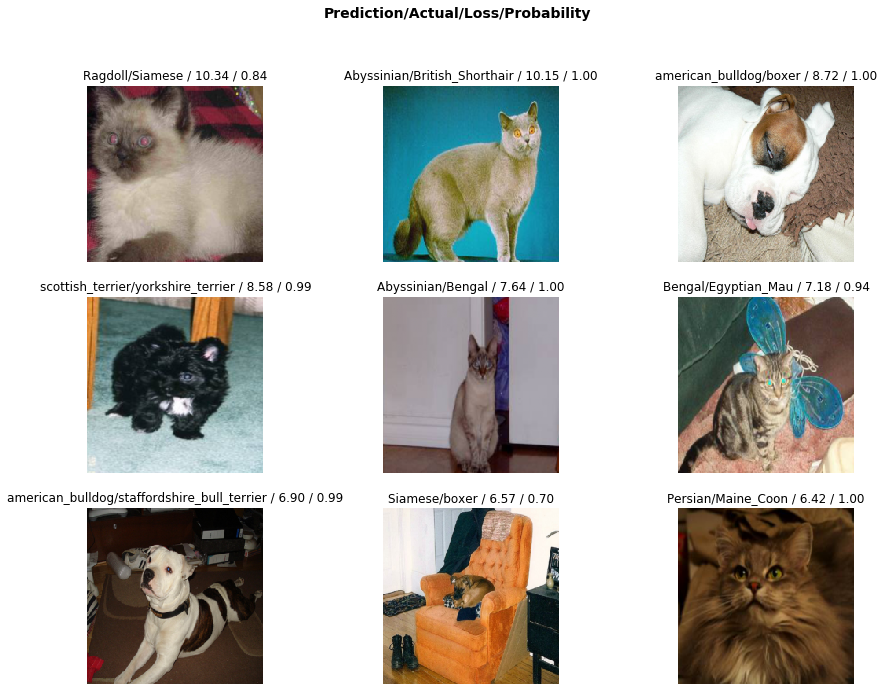

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

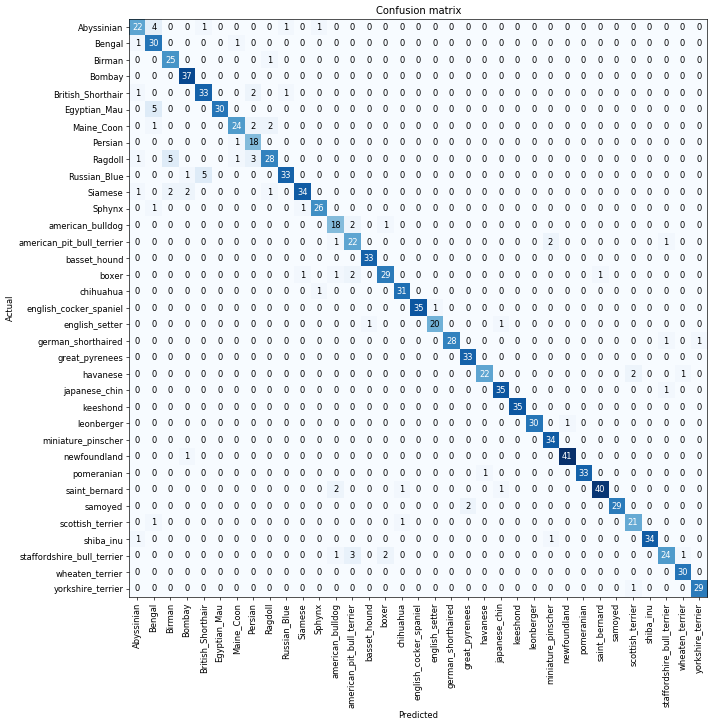

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [28]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Abyssinian', 'Bengal', 4),
 ('Ragdoll', 'Persian', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('British_Shorthair', 'Persian', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Siamese', 'Birman', 2),
 ('Siamese', 'Bombay', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('havanese', 'scottish_terrier', 2),
 ('saint_bernard', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2),
 ('staffordshire_bull_terrier', 'boxer', 2)]

### Test

In [45]:
test_data = TestData(fnames_test,label_func,dbunch)

In [46]:
save_name = save_stem + '_2'
learn.load(save_name)
preds = learn.get_preds(dl=test_data.dl)

In [47]:
pets_accuracy_ce = accuracy(preds[0],test_data.y);pets_accuracy_ce

tensor(0.9092)

## Train pet data with BCE

### Helper funcs

In [10]:
# MultiCategoryBlock expects a list of labels 
# https://forums.fast.ai/t/how-to-use-bcewithlogitslossflat-in-lesson1-pets-ipynb/59146
class RegextraLabeller():
    "Label `item` with regex `pat`."
    def __init__(self, pat): self.pat = re.compile(pat)
        
    def __call__(self, o, **kwargs):
        res = self.pat.search(str(o))
        assert res,f'Failed to find "{self.pat}" in "{o}"'
        return [res.group(1)]
    
def accuracy_one_class(inp, targ, thresh=0.5, sigmoid=True):
    targ = targ.argmax(-1)
    if sigmoid: inp = inp.sigmoid()
    pred_mask = inp > thresh
    pred = pred_mask.float().argmax(-1)
    n_preds = pred_mask.sum(-1)
    pred[n_preds > 1] = -1 # too many predictions
    pred[n_preds == 0] = inp.shape[-1] # class other
    return (targ == pred).float().mean(),pred

def error_rate_oc(inp, targ, thresh=0.5, sigmoid=True):
    return 1 - accuracy_one_class(inp, targ, thresh, sigmoid)[0]

In [11]:
x = torch.tensor([0,0.6,0.20])
y = torch.tensor([0,1,0])
assert accuracy_one_class(x,y,0.5,False)[0] == 1
# argmax non deterministic on CUDA
x = torch.tensor([0,0.6,0.20], device='cuda:0')
y = torch.tensor([0,1,0], device='cuda:0')
assert accuracy_one_class(x,y,0.5,False)[0] == 1
x = torch.tensor([[0,0.6,0.20],[0,0.5,0.2]], device='cuda:0')
y = torch.tensor([[0,1,0],[0,0,1]], device='cuda:0')
assert accuracy_one_class(x,y,0.5,False)[0] ==  0.5
# too few preds
assert accuracy_one_class(x,y,0.6,False)[0] == 0
# too many preds
assert accuracy_one_class(x,y,0.19,False)[0] == 0
# class other
y = torch.tensor([[0,0,0,1],[0,0,0,1]], device='cuda:0')
assert accuracy_one_class(x,y,0.6,False)[0] == 1

In [12]:
x = torch.tensor([0,0.6,0.20])
y = torch.tensor([0,1,0])
assert error_rate_oc(x,y,0.5,False) == 0

### Setup

In [50]:
save_stem = f'{model.__name__}_bce_ex_{"_".join(map(str, i_wild_classes))}'

In [51]:
label_func = RegextraLabeller(pat)
dbunch = create_dbunch(MultiCategoryBlock,valid_pct,seed,label_func,fnames_train_valid,path,item_tfms,bs,
                       num_workers,batch_tfms)

In [52]:
learn = cnn_learner(dbunch, model, metrics=error_rate_oc).to_fp16()

### Train

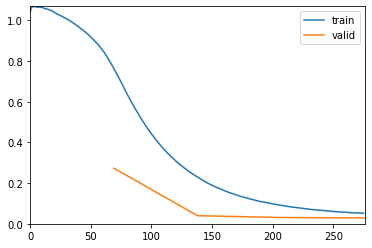

In [16]:
save_name = save_stem + '_1'
learn.fit_one_cycle(4,cbs=[ShowGraphCallback(),
                           SaveModelCallback(monitor='error_rate_oc',fname=save_name,comp=np.less)])

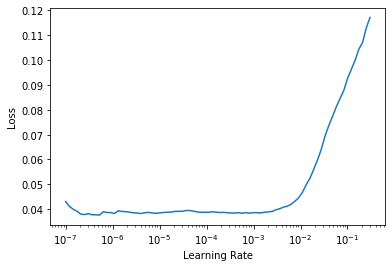

In [17]:
learn.load(save_name)
learn.unfreeze()
learn.lr_find()

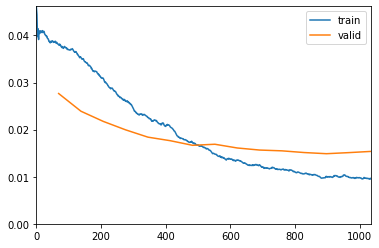

In [18]:
save_name = save_stem + '_1'
learn.load(save_name)
save_name = save_stem + '_2'
learn.fit_one_cycle(15, lr_max=slice(1e-6,1e-3),
                    cbs=[SaveModelCallback(monitor='error_rate_oc',fname=save_name,comp=np.less),
                    ShowGraphCallback()])

### Check Performance

In [19]:
save_name = save_stem + '_2'
learn.load(save_name)
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

AttributeError: 'L' object has no attribute 'show'

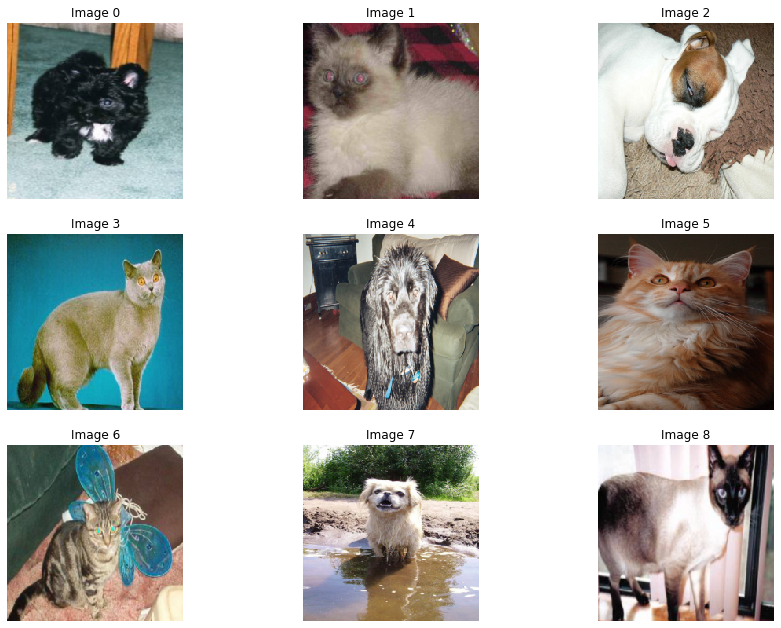

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

###  Test

#### Compare with ce model

In [53]:
test_data = TestData(fnames_test,label_func,dbunch)

In [54]:
ident = np.eye(max(test_data.y)+1)
y_test_oh = torch.from_numpy(ident[test_data.y,:])

In [55]:
save_name = save_stem + '_2'
learn.load(save_name)
preds = learn.get_preds(dl=test_data.dl)

In [56]:
pets_accuracy_bce,_ = accuracy_one_class(preds[0],y_test_oh,0.5,sigmoid=False)
lunch = pets_accuracy_ce - pets_accuracy_bce
print(f'Acc CE: {pets_accuracy_ce*100:.2f}%')
print(f'Acc BCE: {pets_accuracy_bce*100:.2f}%')
print(f'Diff: {lunch*100:.2f}%')

Acc CE: 90.92%
Acc BCE: 83.98%
Diff: 6.94%


#### Performance on unseen classes

##### Setup

In [26]:
from enum import Enum
class Method(Enum):
    MOST_CONFUSED = 1# class for each test image where max prediction was highest
    MAX_LOW = 2 # class for each test image where max prediction was lowest
    LEAST_CONFUSED = 3
    MOST_CONFUSED_CLASS = 4 # class which has the highest average prediction
    LEAST_CONFUSED_CLASS = 5 # class which has the lowest average prediction
            
class TestInterp():
    def __init__(self,test_data,preds,metric,dbunch): # test_data should probably be passed here
        self.metric = metric
        self.preds = preds[0]
        self.y_pred = None
        self.actual_vs_pred = None
        self.test_data = test_data
        self.train_fnames = dbunch.train_ds.items
        self.train_labeller = dbunch.train_ds.tfms[1][0]
        
        tmpL = L(map(self.train_labeller,self.train_fnames))
        if isinstance(tmpL[0],list): # works with bce labellers
            tmpL = [item for sublist in tmpL for item in sublist]
            assert len(tmpL) == len(self.train_fnames)
        self.train_y = np.array(L(map(dbunch.train_ds.vocab.o2i.get,tmpL)))
        self.model_vocab = dbunch.vocab        
        self.model_i2o = {v: k for v, k in enumerate(self.model_vocab)}
        self.model_i2o[len(self.model_i2o)] = "Other"
        self.model_i2o[-1] = ">1"
        
    def calc_metric(self,thresh=0.5,show = False):
        # predict all as class other
        y_oh = torch.zeros(self.preds.shape[0],self.preds.shape[1]+1)
        y_oh[:,-1] = 1
        self.metric_res,self.y_pred = self.metric(self.preds,y_oh,thresh,sigmoid=False)        
        return self.metric_res
        
    def error_mat(self,**kwargs):
        if(self.y_pred is None):
            self.calc_metric(**kwargs)
        self.y_pred_classes = np.unique(self.y_pred)
        self.y_pred_class_labels = np.array(L(map(self.model_i2o.get,self.y_pred_classes)))
        self.actual_vs_pred = np.zeros((self.test_data.n_classes,len(self.y_pred_classes)))
        for i_zi_class in range(0,self.actual_vs_pred.shape[0]):
            i_class,count = np.unique(self.y_pred[self.test_data.y==i_zi_class],return_counts=True)
            # need to get the predicted value aswell
            self.actual_vs_pred[i_zi_class,:] = [count[i==i_class][0] if i in i_class else 0 for i in self.y_pred_classes]
        return self.actual_vs_pred#,i_pred_classes

    def img_from_class(self,class_idx):
        idx = np.where(self.train_y == class_idx)[0]
        i = idx[np.random.choice(len(idx))]
        return PILImage.create(self.train_fnames[i]),self.train_fnames[i]
    
    def show_incorrect(self,pct=False,trans=False):
        if(self.actual_vs_pred is None):
            self.error_mat()
        if pct:
            self.actual_vs_pred = np.true_divide(self.actual_vs_pred, self.actual_vs_pred.sum(axis=1, keepdims=True))

        if trans:
            label_x=L(self.test_data.i2o.values())
            label_bars=self.y_pred_class_labels
            data = self.actual_vs_pred.transpose()
        else:
            label_x=self.y_pred_class_labels
            label_bars=L(self.test_data.i2o.values())
            data = self.actual_vs_pred

        width = 1
        sep = 0.5
        n_bars = len(label_bars)
        n_labels = len(label_x)
        class_width = n_bars*(width+sep)
        x_sep = class_width/2
        x = np.arange(x_sep,n_labels*class_width,class_width)  # the label locations

        fig, ax = plt.subplots()
        rects = []

        x_start = x-(n_bars/2*width)
        x_start = x-(width/2)*(n_bars-1)
        for i in np.arange(n_bars):
            rect = ax.bar(x_start+i*width, data[i,:], width, label=label_bars[i])
            rects.append(rect)

        ax.set_ylabel('Predictions')
        ax.set_title('Predictions by predicted and actual class')
        ax.set_xticks(x)
        ax.set_xticklabels(label_x)
        ax.legend()
        plt.xticks(rotation=90);
        print(label_bars)
        
    def investigate_predictions(self,method,n_to_show=6):
        descending = True
        if method == Method.MOST_CONFUSED:
            pred_classes = self.preds.argmax(dim=1).numpy()
        elif method == Method.MAX_LOW:
            pred_classes = self.preds.argmax(dim=1).numpy()
            descending = False
        elif method == Method.LEAST_CONFUSED:
            pred_classes = self.preds.argmin(dim=1).numpy()
            descending = False
        elif method == Method.MOST_CONFUSED_CLASS:
            pred_classes = np.full((self.preds.shape[0],),self.preds.sum(axis=0).argmax().item())
        elif method == Method.LEAST_CONFUSED_CLASS:
            pred_classes = np.full((self.preds.shape[0],),self.preds.sum(axis=0).argmin().item())        

        pred_class_names = L(map(self.model_i2o.get,pred_classes))
        
        i_pred_classes_dsc = self.preds[np.arange(len(pred_classes)),pred_classes].argsort(descending=descending)
        pred_classes_dsc = pred_classes[i_pred_classes_dsc]        
        preds_to_show = self.preds[i_pred_classes_dsc,pred_classes_dsc]
        preds_to_show_fnames = [self.test_data.fnames[i] for i in i_pred_classes_dsc]
        preds_to_show_class_names = pred_class_names[i_pred_classes_dsc]

        fig_cols = 12
        fig_rows = n_to_show*4
        n_cols = 2
        fig,axs = plt.subplots(n_to_show,n_cols, figsize=(fig_cols,fig_rows))
        if(n_to_show == 1):
            axs = np.expand_dims(axs, axis=0)
        fig.tight_layout()
        i_sp = 0
        for i in range(0,n_to_show):            
            img_actual = PILImage.create(preds_to_show_fnames[i_sp])
            title = f'A: {self.test_data.labeller(preds_to_show_fnames[i_sp])}, P: {preds_to_show_class_names[i_sp]} {preds_to_show[i_sp]:.2f}'
            img_actual.show(ctx=axs[i,0], title=title);
            img_pred,_ = self.img_from_class(pred_classes_dsc[i_sp])
            title = f'Random: {preds_to_show_class_names[i_sp]}'
            img_pred.show(ctx=axs[i,1], title=title);
            i_sp +=1

##### Similar Classes

In [27]:
test_data = TestData(fnames_wild,label_func,dbunch)

In [28]:
save_name = save_stem + '_2'
learn.load(save_name)
preds = learn.get_preds(dl=test_data.dl)

(#2) [beagle,pug]


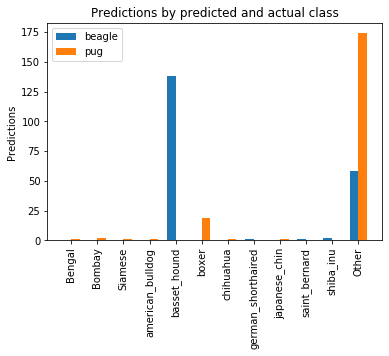

In [29]:
test_interp = TestInterp(test_data,preds,accuracy_one_class,dbunch)
test_interp.show_incorrect()

In [37]:
test_interp.calc_metric()

tensor(0.5800)

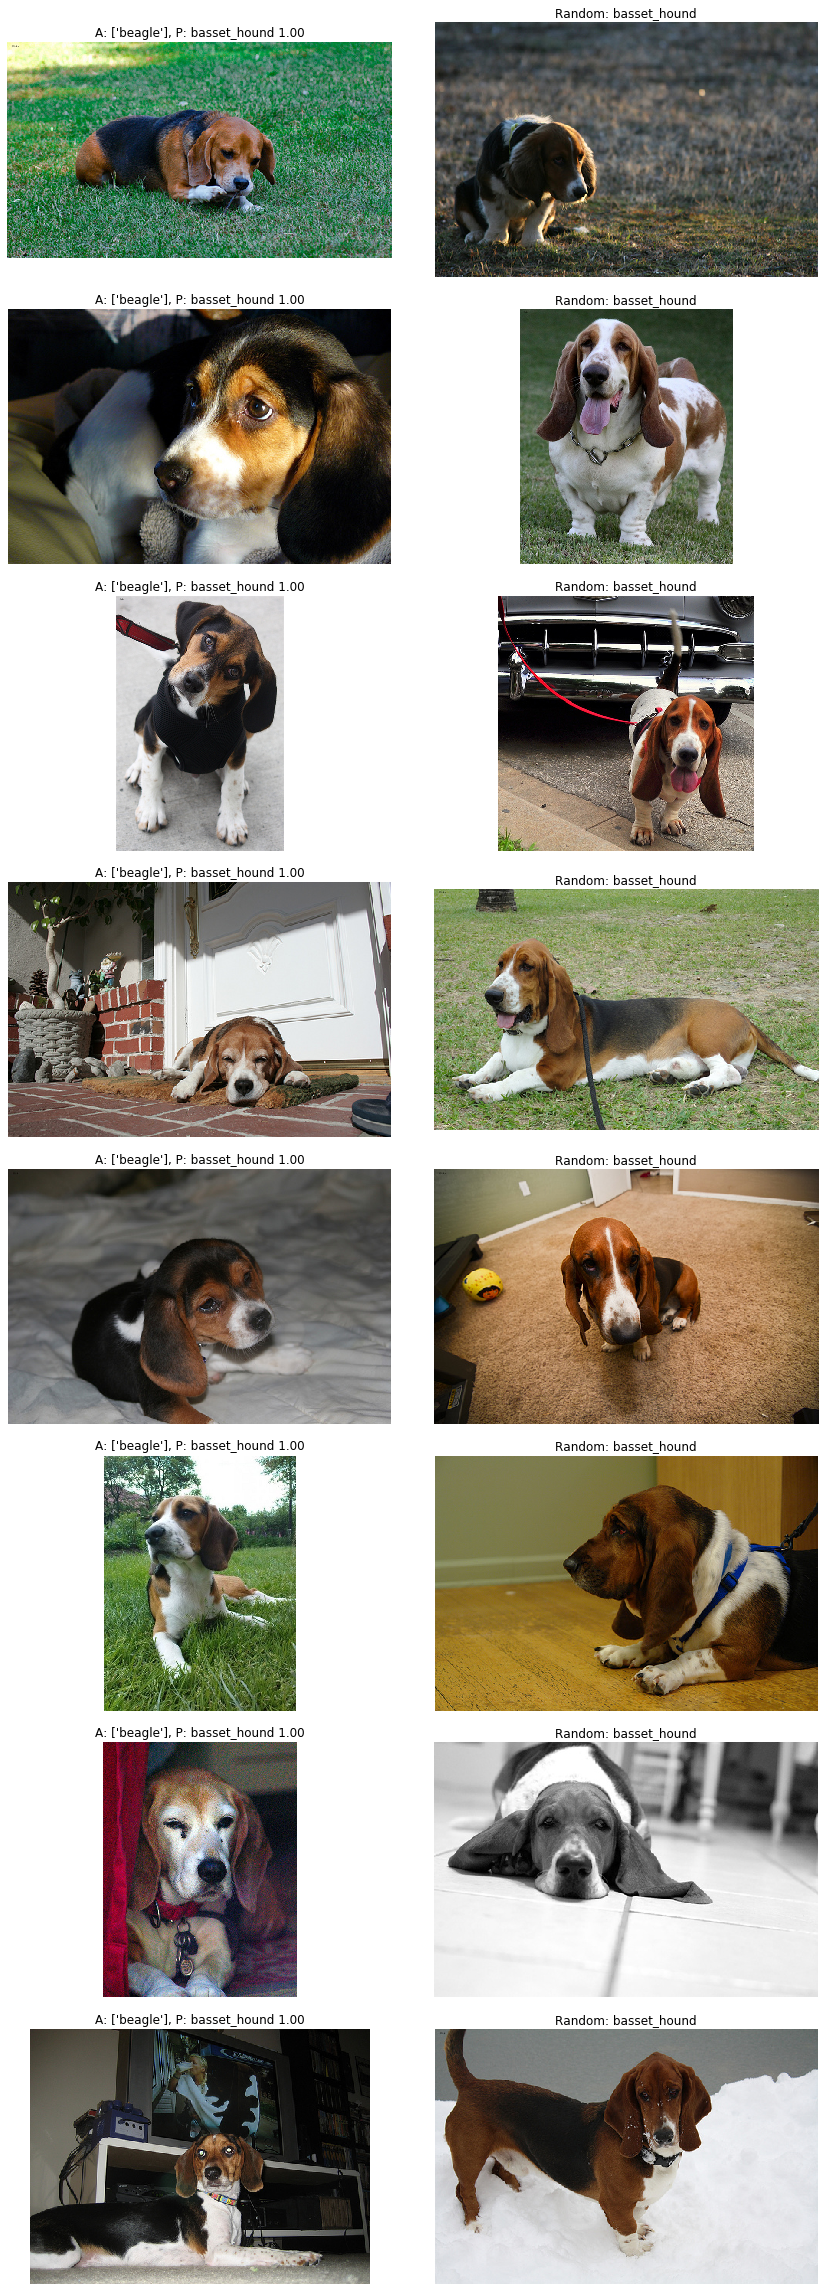

In [30]:
test_interp.investigate_predictions(Method.MOST_CONFUSED_CLASS,8)

##### Imagenette

In [31]:
path_extra = untar_data(URLs.IMAGENETTE_320)

In [32]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)
fnames_imagenette = get_image_files(path_extra/"train")
labeller_imagenette = Pipeline([parent_label, lbl_dict.__getitem__])
test_data_imagenette = TestData(fnames_imagenette,labeller_imagenette,dbunch)

In [33]:
save_name = save_stem + '_2'
learn.load(save_name)
preds_imagenette = learn.get_preds(dl=test_data_imagenette.dl)

(#10) [English springer,French horn,cassette player,chain saw,church,garbage truck,gas pump,golf ball,parachute,tench]


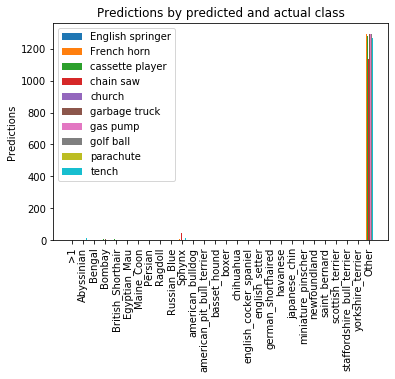

In [35]:
test_interp_imagenette = TestInterp(test_data_imagenette,preds_imagenette,accuracy_one_class,dbunch)
test_interp_imagenette.show_incorrect()

In [38]:
test_interp_imagenette.calc_metric()

tensor(0.9510)

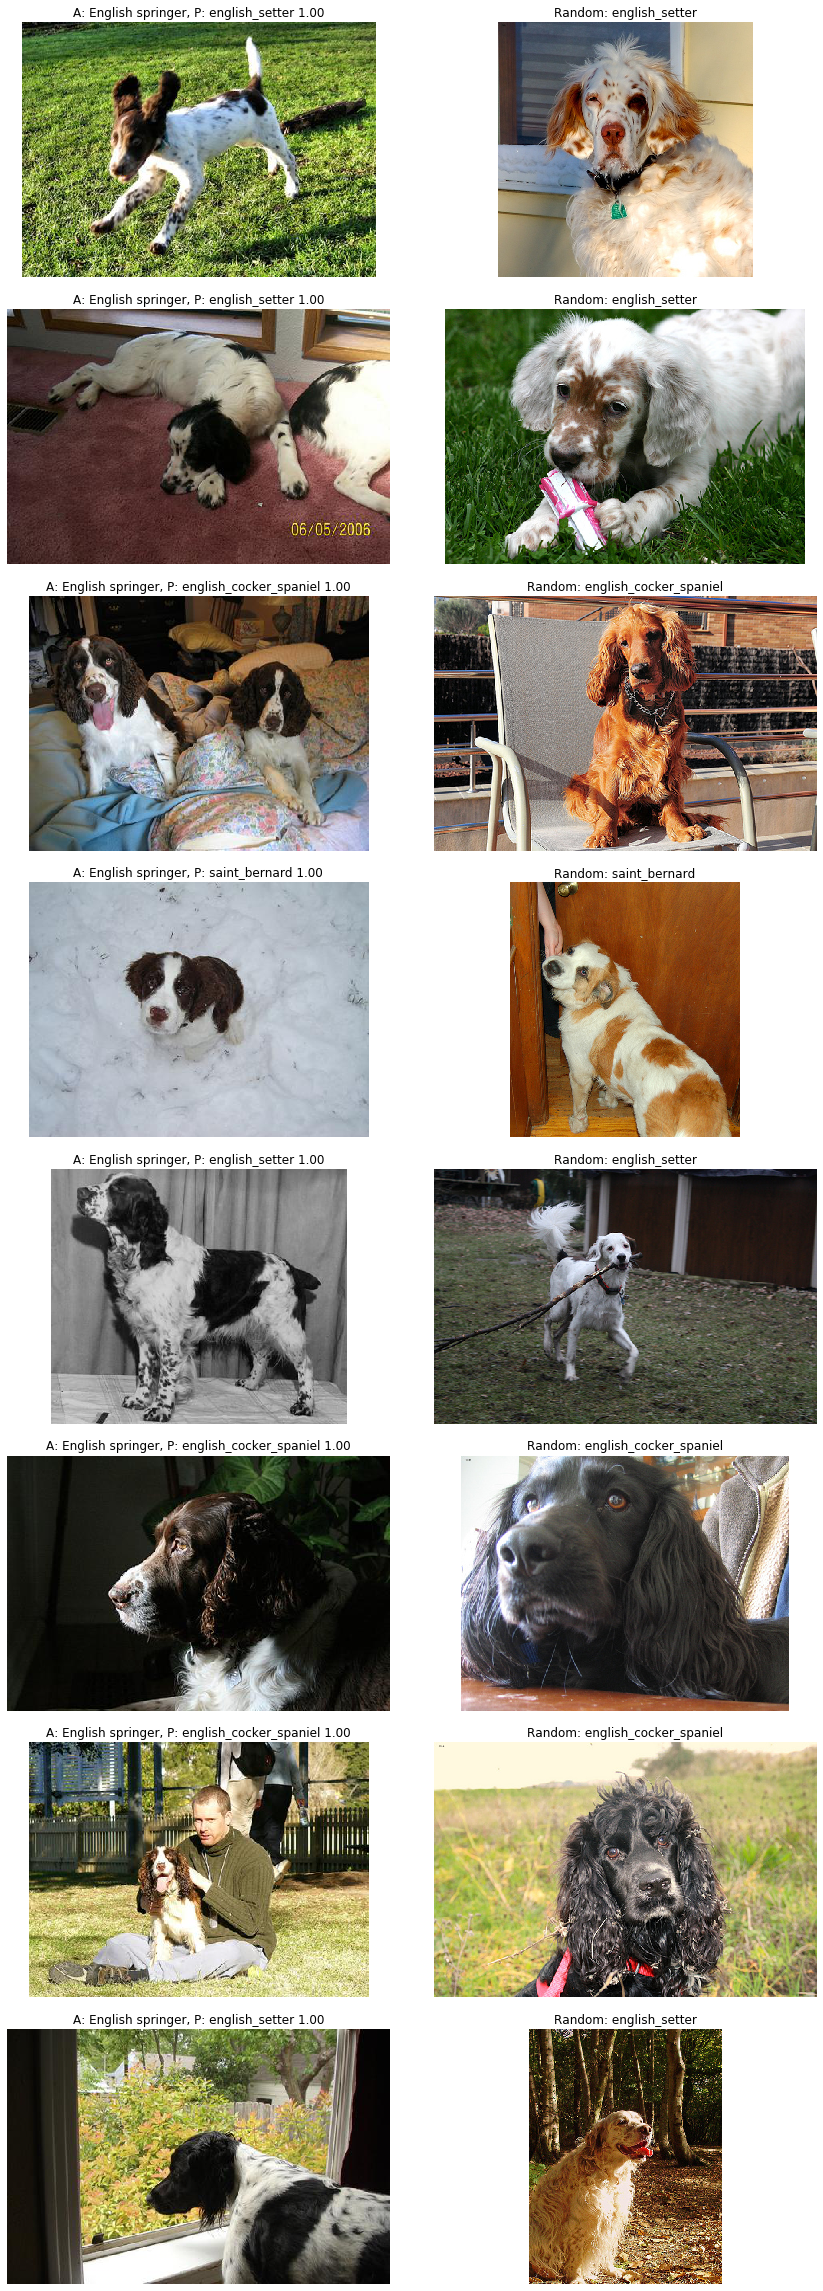

In [36]:
test_interp_imagenette.investigate_predictions(Method.MOST_CONFUSED,8)